In [6]:
import sys
sys.path.append('../')

from PIL import Image
import numpy as np
from raypy.utils.vector3 import vec3

In [54]:
class Ray:
  """Info of the ray and the media it's travelling"""

  def __init__(self, origin, dir):
      self.origin = origin  # the point where the ray comes from
      self.dir = dir  # direction of the ray

In [55]:
class Camera():
  def __init__(self, look_from, look_at, screen_width=400, screen_height=300, field_of_view=90., aperture=0.):
    self.screen_width = screen_width
    self.screen_height = screen_height
    self.aspect_ratio = float(screen_width) / screen_height

    self.look_from = look_from
    self.look_at = look_at
    fov_in_rad = field_of_view * np.pi / 180
    self.viewport_width = np.tan(fov_in_rad / 2.) * 2.
    self.viewport_height = self.viewport_width / self.aspect_ratio

    # camera reference basis in world coordinates
    self.cameraFwd = (look_at - look_from).normalize()
    self.cameraRight = (self.cameraFwd.cross(vec3(0., 1., 0.))).normalize()
    self.cameraUp = self.cameraRight.cross(self.cameraFwd)

    # Pixels coordinates in camera basis:
    self.x = np.linspace(-self.viewport_width / 2., self.viewport_width / 2., self.screen_width)
    self.y = np.linspace(self.viewport_height / 2., -self.viewport_height / 2., self.screen_height)

    # x holds all x values
    # y holds all y values
    # meshgrid creates a rectangular grid with all combinations of (x,y)
    # xx and yy hold the x and y values of the rectangular grid: https://stackoverflow.com/a/42404323
    xx, yy = np.meshgrid(self.x, self.y)
    self.x = xx.flatten()
    self.y = yy.flatten()

  def get_ray(self, n):  # n = index of refraction of scene main medium (for air n = 1.)
    # in each pixel, take a random position to avoid aliasing.
    x = self.x + (np.random.rand(len(self.x)) - 0.5) * self.viewport_width / self.screen_width
    y = self.y + (np.random.rand(len(self.y)) - 0.5) * self.viewport_height / self.screen_height
    # max offset is the width of 0.5 pixels

    # set ray direction in world space:
    # ray_origin = self.look_from + self.cameraRight * self.lens_radius + self.cameraUp * self.lens_radius
    ray_origin = self.look_from
    ray_dir = (self.look_from + self.cameraUp * y + self.cameraRight * x + self.cameraFwd - ray_origin).normalize()
    return Ray(origin=ray_origin, dir=ray_dir)

In [63]:
camera = Camera(screen_width=300 ,screen_height=300, look_from = vec3(0, 0, 10), look_at = vec3(0,0,0), field_of_view= 90)
rays = camera.get_ray(index_of_refraction)
color = rays.dir.to_array()
print(color.shape)

(3, 90000)


Rays ist eine Matrix.
Sie beinhaltet alle Richtungsvektoren der Rays für alle Pixel
Die Matrix hat also 3 Zeilen und 300*300 = 90000 Spalten.

Im Folgenden wird jedes Zeile der Matrix in ein einzelnes 300x300 Bild in Graustufen umgewandelt.
Danach werden die drei Bilder im RGB Modus zusammengeführt.

In [67]:
img_RGB = []
for channel in color:
    img_RGB += [Image.fromarray((255 * np.clip(channel, 0, 1).reshape((camera.screen_width, camera.screen_height))).astype(np.uint8), "L")]


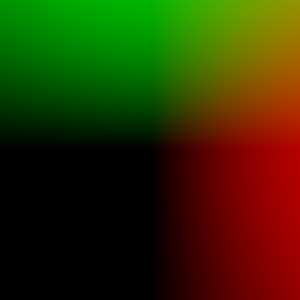

In [68]:
img = Image.merge("RGB", img_RGB)
display(img)

Das Bild zeigt die Richtungsvektoren der Rays.
Der x-Wert (Rot) steigt nach rechts an.
Der y-Wert (Grün) steigt nach oben an.
Der z-Wert ist 0 weil negative Werte für Blau nicht angezeigt werden können.
Würde man den Betrag des Z-Wertes angeben, 